In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
df = pd.read_csv("mnist/mnist_train.csv")[0:5000]
data = df.to_numpy()
X = data[:,1:] / 255
Y = df.label.to_numpy()
y1h = pd.get_dummies(df.label).to_numpy()
m, n = X.shape
c = y1h.shape[1]
print(X.shape, Y.shape, y1h.shape)

(5000, 784) (5000,) (5000, 10)


In [3]:
def score(X, w, b):
    return X.dot(w) + b
def softmax(x):
    e = np.exp(x)
    return e/np.sum(e, axis=1, keepdims=True)
def RELU(x):
    return np.maximum(0, x)
def ReLU_deriv(x):
    return x > 0
def lossSoftmax(softmaxScore, y1h):
    a = np.multiply(softmaxScore, y1h)
    b = np.sum(a,axis=1, keepdims=True)
    c = -np.log(b)
    return np.mean(c)
def accuracyOfModel(score, Y):
    return np.mean(np.argmax(score, axis=1) == Y)
def convXF(x, f):
    cln = []
    m, n, _ = x.shape
    o = f.shape[0]
    for m in range(m):
        tmp = []
        for i in range(n-o+1):
            for j in range(n-o+1):
                tmp.append(x[m][i:i+o, j:j+o].flatten().dot(f.flatten().T))
        cln.append(tmp)
    return np.array(cln).reshape(m+1, n-o+1, n-o+1)

def maxPool(z, o):
    m, n, _ = z.shape
    pl=[]
    for m in range(m):
        tmp = []
        for i in range(0, n, o):
            for j in range(0, n, o):
                tmp.append(np.max(z[m][i:i+o, j:j+o]))
        pl.append(tmp)
    return np.array(pl).reshape(len(pl), int(n/o), int(n/o))
def maxIndices(x):
    a = np.argmax(x)
    b = x.shape[1]
    indices = (int(a/b), int(a%b))
    return indices
def backPropMaxPool(x, p, o):
    z_t = np.zeros(x.shape)
    m, n, _ = z_t.shape
    for m in range(m):
        for i in range(0, n, o):
            for j in range(0, n, o):
                maxI = maxIndices(x[m][i:i+o, j:j+o])
                z_t[m][i+maxI[0], j+maxI[1]] = p[i,j]
    return z_t

## CNN

### Forward Pass

In [4]:
#Conv layer
x = X.reshape(X.shape[0], int(math.sqrt(X.shape[1])), int(math.sqrt(X.shape[1])))
f = np.random.randn(3,3) * 0.5
z1 = convXF(x, f)
p1 = maxPool(z1,2)

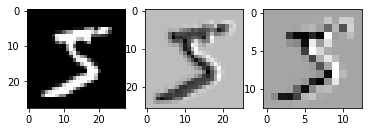

In [5]:
plt.subplot(1,3,1)
plt.imshow(x[0],cmap='gray')
plt.subplot(1,3,2)
plt.imshow(z1[0],cmap='gray')
plt.subplot(1,3,3)
plt.imshow(p1[0],cmap='gray')
plt.show()

In [6]:
#Softmax Layer
p1f = p1.reshape(p1.shape[0], p1.shape[1] **2)
m, n = p1f.shape
c = y1h.shape[1]
print(m,n,c)

5000 169 10


In [7]:
w2 = 0.05 * np.random.randn(n, c)
b2 = 0.05 * np.random.randn(1, c)

In [8]:
z2 = score(p1f, w2, b2)
a2 = softmax(z2)
loss = lossSoftmax(a2, y1h)

### Backward Pass

In [9]:
#Gradients
#Softmax Layer
dz2 = (1/m) * (a2 - y1h)
dw2 = p1f.T.dot(dz2)
db2 = np.sum(dz2, axis=0, keepdims=True)

# Conv Layer
dp1 = dz2.dot(w2.T)
dp1_b =  np.sum(backPropMaxPool(z1, dp1, 2), axis=0)
drf = (1/m) * np.sum(convXF(x, dp1_b), axis=0)

In [10]:
dp1_b.shape

(26, 26)

In [11]:
x.shape

(5000, 28, 28)

In [12]:
convXF(x, dp1_b).shape

(5000, 3, 3)

## Gradient Decent

In [10]:
f = np.random.randn(3,3) * 0.5
w2 = 0.05 * np.random.randn(n, c)
b2 = 0.05 * np.random.randn(1, c)

In [ ]:
lr = 0.01
itr = 100
for i in range(itr+1):
    #Forward Pass
    #Conv layer
    x = X.reshape(X.shape[0], int(math.sqrt(X.shape[1])), int(math.sqrt(X.shape[1])))
    z1 = convXF(x, f)
    p1 = maxPool(z1,2)
    #Softmax Layer
    p1f = p1.reshape(p1.shape[0], p1.shape[1] **2)
    m, n = p1f.shape
    c = y1h.shape[1]
    z2 = score(p1f, w2, b2)
    a2 = softmax(z2)
    loss = lossSoftmax(a2, y1h)
    
    #Gradients
    #Softmax Layer
    dz2 = (1/m) * (a2 - y1h)
    dw2 = p1f.T.dot(dz2)
    db2 = np.sum(dz2, axis=0, keepdims=True)

    # Conv Layer
    dp1 = dz2.dot(w2.T)
    dp1_b =  np.sum(backPropMaxPool(z1, dp1, 2), axis=0)
    drf = (1/m) * np.sum(convXF(x, dp1_b), axis=0)
    
    #Weights and Bias Update
    f -= lr*drf
    w2 -= lr*dw2
    b2 -= lr*db2
    if i%10==0:
        print(i, loss, accuracyOfModel(a2, Y))

0 0.7124861670901927 0.8288
10 0.6894747889920914 0.8314
20 0.668517569885773 0.8366
30 0.6493717326258578 0.8398
40 0.6318341061935397 0.8446
50 0.6157238238715156 0.8482
